In [450]:
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy.stats
import scipy.optimize

In [451]:
# load data from yfinance, format in CSV-File and prepare for usage

#yfinance.download(['RWE.DE', 'IBE.MC', 'ORSTED.CO', 'ENEL.MI', 'INRG.L'], interval='1mo').to_csv('combined.csv')

#pd.read_csv('combined.csv')[['Price', 'Close', 'Close.1', 'Close.2', 'Close.3', 'Close.4']].dropna().to_csv('data.csv', index=False)

data = pd.read_csv('data.csv',index_col=['Date'],date_format=['Date'])

ticker = ['ENEL.MI', 'IBE.MC', 'INRG.L', 'ORSTED.CO', 'RWE.DE']

for i in range(len(ticker)):
    data.loc[:, "logreturn_" + ticker[i]] = np.log(data[ticker[i]]) - np.log(data[ticker[i]].shift())

data = data.dropna()

data.head()


,ENEL.MI,IBE.MC,INRG.L,ORSTED.CO,RWE.DE,logreturn_ENEL.MI,logreturn_IBE.MC,logreturn_INRG.L,logreturn_ORSTED.CO,logreturn_RWE.DE
Date,,,,,,,,,,
2016-07-01,2.562863,4.207121,398.191650,237.851883,12.512494,0.074700,0.009483,0.038088,0.120231,0.114096
2016-08-01,2.463286,4.143828,408.478516,232.322464,11.536983,-0.039629,-0.015159,0.025506,-0.023522,-0.081170
2016-09-01,2.469510,4.250585,407.979156,241.362610,12.064075,0.002523,0.025436,-0.001223,0.038174,0.044674
2016-10-01,2.439636,4.360852,421.711700,235.833221,11.375710,-0.012171,0.025611,0.033106,-0.023176,-0.058752
2016-11-01,2.373667,4.001112,369.927704,210.204865,9.330283,-0.027413,-0.086095,-0.131014,-0.115042,-0.198215


# Checking for normal distribution

With an alpha of 0.05

In [452]:
JB = np.zeros((len(ticker)))



for i in range(len(ticker)):
    S = scipy.stats.skew(data["logreturn_" + ticker[i]])
    K = scipy.stats.kurtosis(data["logreturn_" + ticker[i]], fisher=False)
    N = data.shape[0]
    JB[i] = (N / 6) * (S**2 + 0.25 * (K - 3)**2)


JB
    

array([3.98531342, 6.9008758 , 9.26127031, 5.37185235, 5.27292224])

In [453]:
cdf = np.zeros((len(ticker)))

for i in range(len(ticker)):
    cdf[i] = scipy.stats.chi2.cdf(JB[i], 2)

cdf


array([0.86366725, 0.96826826, 0.99025143, 0.93184196, 0.92838574])

In [454]:
a = 0.05

p = np.zeros((len(ticker)))

for i in range(len(ticker)):
    p[i] = 1 - cdf[i]
    if p[i] > a:
        print(ticker[i] + ": probably normal distributed")
    else: 
        print(ticker[i] + ": not normal distributen")

p

ENEL.MI: probably normal distributed
IBE.MC: not normal distributen
INRG.L: not normal distributen
ORSTED.CO: probably normal distributed
RWE.DE: probably normal distributed


array([0.13633275, 0.03173174, 0.00974857, 0.06815804, 0.07161426])

## Interpretation

The analysis using the Jarque-Bera test indicates, that IBE.MC and INRG.L are not normal distributed. This deviation implies a higher likelihood of extreme return outcomes than predicted by the normal distribution assumption. As a result, mean-variance optimization — which relies on variance as a complete risk measure — may underestimate the true risk of these assets.

# Build the IOS

In [455]:

mu = np.zeros((len(ticker)))

for i in range(len(ticker)):
    mu[i] = np.mean(data["logreturn_" + ticker[i]])*12

Sigma = np.cov(data[['logreturn_ENEL.MI', 'logreturn_IBE.MC', 'logreturn_INRG.L', 'logreturn_ORSTED.CO', 'logreturn_RWE.DE']].T)*12

print(mu)
print(Sigma)


[0.13218888 0.14508461 0.04186212 0.02225458 0.11922108]
[[0.04606144 0.03198705 0.0162549  0.02258017 0.03524565]
 [0.03198705 0.03734094 0.0217247  0.02188248 0.03122188]
 [0.0162549  0.0217247  0.07364653 0.03415299 0.0370022 ]
 [0.02258017 0.02188248 0.03415299 0.09237534 0.03694778]
 [0.03524565 0.03122188 0.0370022  0.03694778 0.0853863 ]]


# Building a Efficient Frontier

## 1. unconstrained

In [456]:
def portfolio_variance(w):
    #input: w as  numpy column vector
    #output: scalar
    return (w.T@Sigma@w).item()

def eq_portfolio_return(w):
    #input: numpy portfolio column vector
    #note: mu_i is a global variable; needs to be known before calling this function
    #output: difference between w's expected return and the target return; scalar
    
    return (w.T@mu).item() - mu_i #constraint to meet target expected return mu_i


def eq_weight_sum(w): 
    #content: full investment constraint: 100% is invested in risky assets
    #input: numpy portfolio column vector
    #output: difference between sum of portfolio holdings and 100%=1. 
    
    return np.sum(w) - 1

#starting values
w0 = [0.2, 0.2, 0.2, 0.2, 0.2] #equal weight for each asset

#bounds 
bounds = [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

#constrains
constraints = [{'type': 'eq', 'fun': eq_portfolio_return},
               {'type': 'eq', 'fun': eq_weight_sum}
               ] #target return and full investment constraint

In [457]:
#loop through y-axis

mu_min = 0.01
mu_max = 1
incr = 0.001

In [458]:
#number of evaluations (i.e. number of optimizations)
nr_evals = int( (mu_max - mu_min) / incr + 1)
nr_evals #number of portfolios on the MV-frontier

991

In [459]:
# MV-Frontier

w_MV = np.zeros((nr_evals, 5))
mu_MV = np.zeros((nr_evals,))
sigma_MV = np.zeros((nr_evals,))

mu_i = mu_min
for i in range(0,nr_evals):
    w_opt = scipy.optimize.minimize(portfolio_variance, w0, constraints=constraints)
    w_MV[i,:] = w_opt.x
    mu_MV[i] = (w_opt.x.T@mu).item()  #MU: come back here.
    sigma_MV[i] = (w_opt.x.T@Sigma@w_opt.x).item()**0.5
    
    mu_i = mu_i + incr

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_58142/852197012.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(r)$')


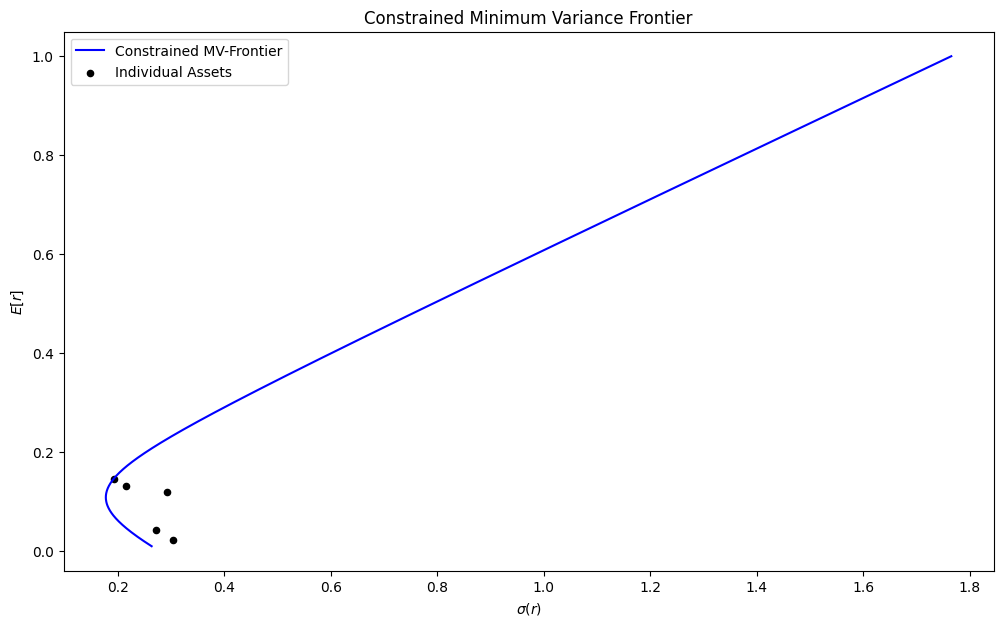

In [460]:
# Plot MV-Frontier

plt.figure(1, figsize=(12,7))

#show the MV-frontier that obeys constraints and bounds
plt.plot(sigma_MV, mu_MV, color='blue',label='Constrained MV-Frontier')

# add single assets investment opportunities
plt.scatter(np.diag(Sigma)**0.5, mu, s=20, color='black', label='Individual Assets')

#descrive axis
plt.xlabel('$\sigma(r)$')
plt.ylabel('$E[r]$')

plt.legend()

#add a title
plt.title('Constrained Minimum Variance Frontier')
plt.show()

In [461]:
p = 990

print(mu_MV[p])
print(w_MV[p])
print(np.sum(w_MV[p]))

print(np.argmin(sigma_MV))

1.0000000000465206
[-1.65996515  8.80878555 -4.03068271 -3.74015012  1.62201243]
0.9999999999999998
99


## 2. Constrained
To ensure realistic implementable portfolio weight, we allow no short-positions and no leverage.

In [462]:
#loop through y-axis

mu_min = 0.01
mu_max = 0.2
incr = 0.001

In [463]:
#number of evaluations (i.e. number of optimizations)
nr_evals = int( (mu_max - mu_min) / incr + 1)
nr_evals #number of portfolios on the MV-frontier

191

In [464]:
# MV-Frontier

w_MV = np.zeros((nr_evals, 5))
mu_MV = np.zeros((nr_evals,))
sigma_MV = np.zeros((nr_evals,))

mu_i = mu_min
for i in range(0,nr_evals):
    w_opt = scipy.optimize.minimize(portfolio_variance, w0, bounds=bounds, constraints=constraints)
    w_MV[i,:] = w_opt.x
    mu_MV[i] = (w_opt.x.T@mu).item()  #MU: come back here.
    sigma_MV[i] = (w_opt.x.T@Sigma@w_opt.x).item()**0.5
    
    mu_i = mu_i + incr

# Tangency Portfolio
 As the risk-free rate, we choose Germany's 10-Year Bund with a 2.7% return.

In [465]:
rf = 0.027

SR_MV = (mu_MV - rf) / sigma_MV

TP_index = np.argmax(SR_MV)

TP_index

134

In [466]:
w_TP = w_MV[TP_index]
w_TP

array([8.41061454e-02, 9.15893855e-01, 0.00000000e+00, 1.02695630e-15,
       0.00000000e+00])

In [467]:
mu_TP = mu_MV[TP_index]
mu_TP

0.1440000008883342

In [468]:
sigma_TP = sigma_MV[TP_index]
sigma_TP

0.19125319867191434

In [469]:
SR_TP = (mu_TP - rf) / sigma_TP
SR_TP

0.6117544788834726

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_58142/907976700.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(r)$')


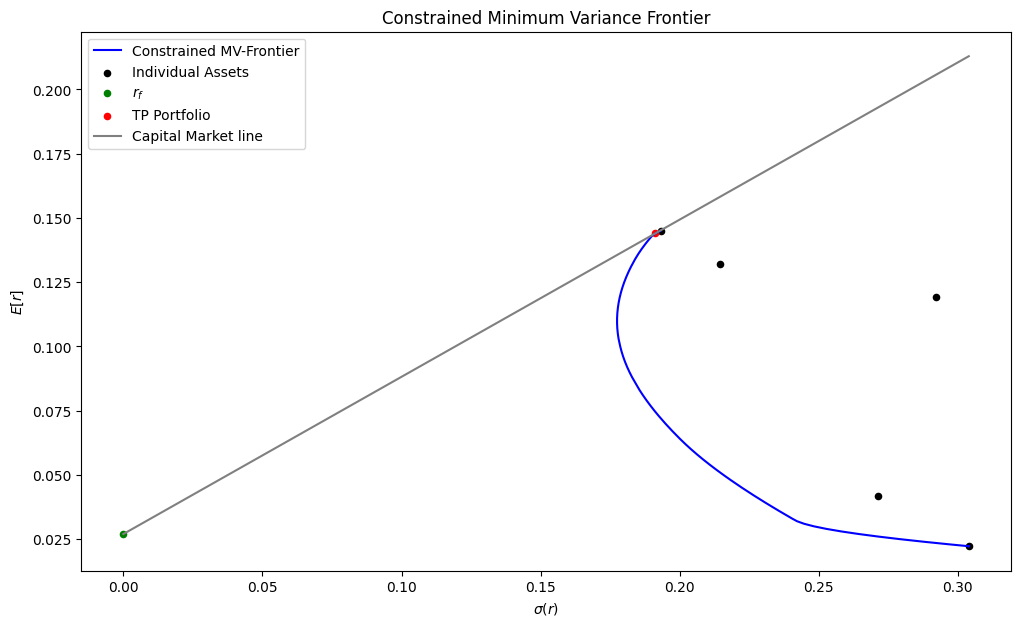

In [470]:
# Plot MV-Frontier

plt.figure(1, figsize=(12,7))

#show the MV-frontier that obeys constraints and bounds
plt.plot(sigma_MV, mu_MV, color='blue',label='Constrained MV-Frontier')

# add single assets investment opportunities and risk-free asset
plt.scatter(np.diag(Sigma)**0.5, mu, s=20, color='black', label='Individual Assets')
plt.scatter([0], [rf], s = 20, color='green', label='$r_f$')
plt.scatter(sigma_TP, mu_TP, s = 20, color='red', label='TP Portfolio')

# add capital market line
x = np.linspace(0, np.max(sigma_MV))
y = rf + SR_TP * x
plt.plot(x, y, color='grey', label='Capital Market line')

#descrive axis
plt.xlabel('$\sigma(r)$')
plt.ylabel('$E[r]$')

plt.legend()

#add a title
plt.title('Constrained Minimum Variance Frontier')
plt.show()

# Optimal Complete Portfolio

Ris Aversion = 3 (medium)

In [479]:
A = 3

y = (mu_TP - rf) / (A * (sigma_TP ** 2))

y

1.0662209105199645

# Decomposing expected portfolio performance (return and risk) using CAPM Model